In [18]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd

mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20

%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

# Data pre-processing

/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


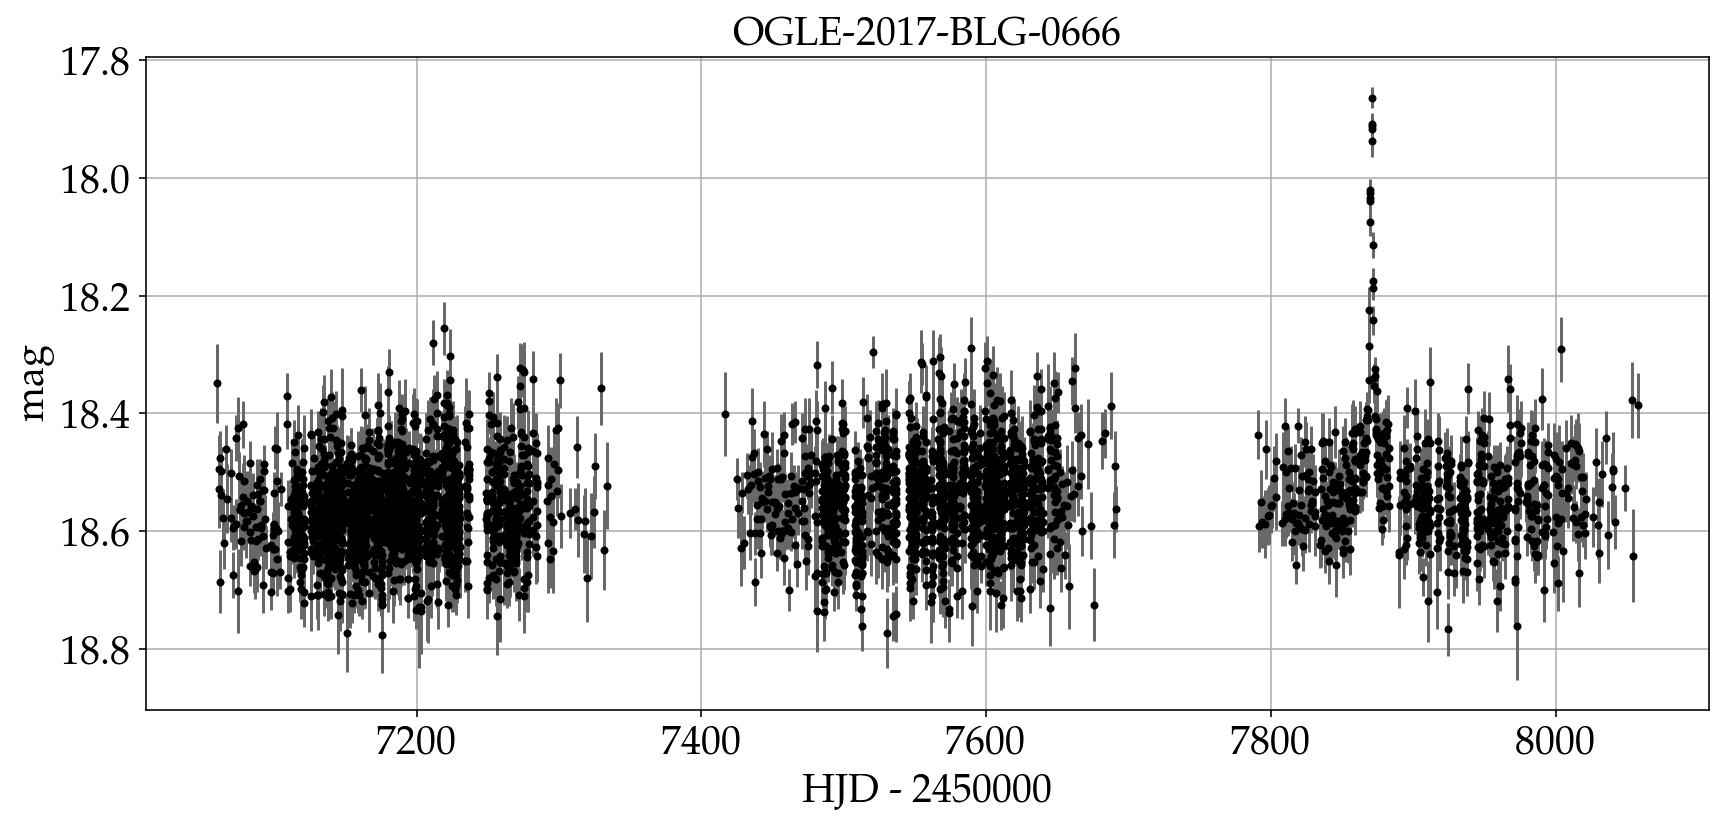

In [50]:
def load_data(path_to_data):
    data = pd.read_csv(path_to_data + '/phot.dat', 
                       names=['HJD', 'I_mag', 'I_mag_err', 'seeing_est', 'sky_level'],
                       delim_whitespace=True)
    
    return (data['HJD'].values - 2450000), data['I_mag'].values, data['I_mag_err'].values
    
def plot_data(ax, x, y, y_err):
    ax.errorbar(x, y, y_err, fmt='.', color='black', label='Data', ecolor='#686868')
    ax.grid(True)

fig, ax = plt.subplots(figsize=(14,6))

t, m, m_err = load_data('../microlensing_data/OGLE/2017/blg-0666/') #714

plot_data(ax, t, m, m_err);
ax.set_xlabel('HJD - 2450000')
ax.set_ylabel('mag')
ax.set_title('OGLE-2017-BLG-0666');
plt.gca().invert_yaxis()

The microlensing surveys do not report fluxes, rather, they report magnitudes which are related to fluxes via

$$m-m_0=-2.5\log_{10}\left(\frac{F}{F_0}\right)$$


where the fluxes are  measured in a certain passband and the reference flux is usually taken to be that of
Vega, in that case $m_0$ is defined to be zero. We are going to define $m_0$ to be 22 such that
a flux $F=1$ corresponds to a mag 22 star. 

The flux as a function of a measured magnitude is then given by

$$\log_{10} F=\frac{m_0-m}{2.5}$$

changing the base of the logarithm to the natural logithm results in

$$\ln F(m)=\frac{m_0-m}{2.5\log_{10}e}$$

Most microlensing surveys report standard errors in magnitudes rather than in fluxes, however, our model works with fluxes. We thus need to transform the magnitude errors to flux errors.

Taking the expectation value of $\ln F$, we have

$$\mathbb{E}[\ln F]=\frac{m_0}{2.5\log_{10}e}-\mathbb{E}[m]$$

$$\mathbb{Var}\,(\ln F)=\frac{\mathbb{Var}\,(m)}{(2.5\log_{10}e)^2}$$

Thus, we see that $\ln F$ is distributed as

$$\ln F\sim\mathcal{N}\left(\frac{m_0}{2.5\log_{10}e}-\mu_m,\frac{\sigma_m}{2.5\log_{10}e}
\right)=\mathcal{N}\left(\mu_{\ln F},\sigma_{\ln F}\right)$$

Since the logarithm of $F$ is given by a Normal distribution, the distribution of $F$ will be log-normal

$$F\sim\textrm{Lognormal}\,\left(\mu_{\ln F},\sigma_{\ln F}\right)$$

The mean and the variance of the Lognormal distribution is given by (see Wikipedia)

$$\mathbb{E}[F]=\exp(\mu_{\ln F}+\frac{1}{2}\sigma_{\ln F}^2)$$
$$\mathbb{Var}\,(F)=\left[\exp(\sigma_{\ln F}^2)-1\right]\exp(2\mu_{\ln F}+\sigma_{\ln F}^2)$$

Because it is easier to work with a Normal distribution rather than a Lognormal, we'll approximate the Lognormal distribution with a Normal distribution with the same mean and variance.

/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


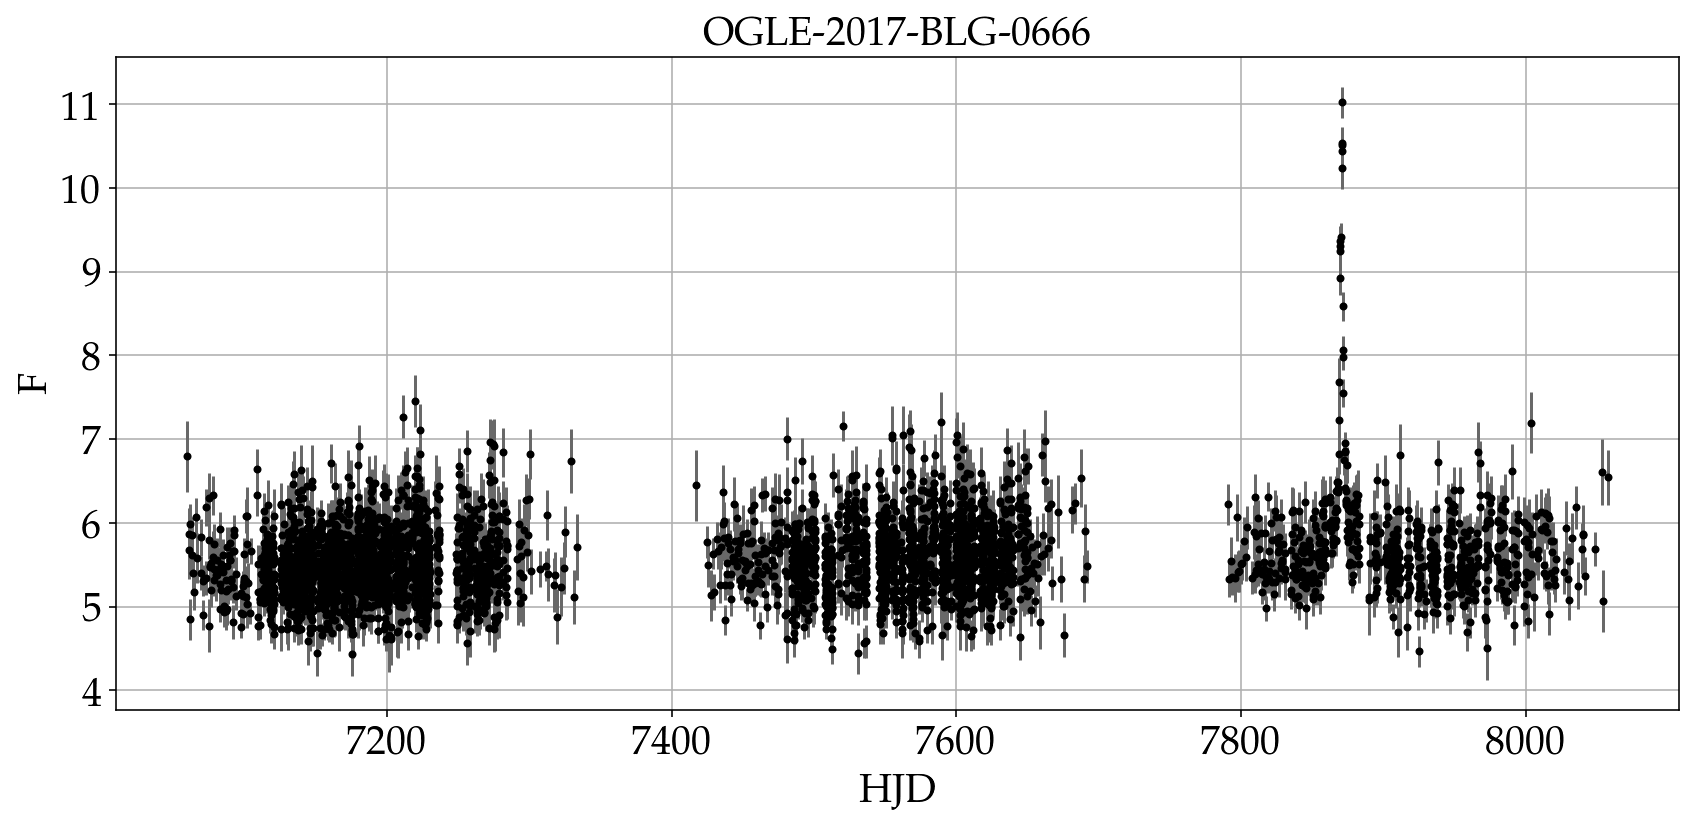

In [51]:
 def magnitudes_to_fluxes(m, sig_m, m0):
    """Given the mean and the standard deviation of a magnitude, assumed to be normally
    distributed, and a reference magnitude m0, this function returns the mean and the 
    standard deviation of a Flux, which is log-normally distributed."""
    
    e = np.exp(1)
    mu_lnF = m0/(2.5*np.log10(e)) - m
    sig_lnF = sig_m/(2.5*np.log10(e))
    
    mu_F = np.exp(mu_lnF + 0.5*sig_lnF**2)
    sig_F = np.sqrt((np.exp(sig_lnF**2) - 1)*np.exp(2*mu_lnF + sig_lnF**2))
    
    return mu_F, sig_F


fig, ax = plt.subplots(figsize=(14,6))

mu_F, sig_F = magnitudes_to_fluxes(m, m_err, 22.)

# sig_F = m_err*mu_F

plot_data(ax, t, mu_F, sig_F);
ax.set_xlabel('HJD - 2450000')
ax.set_ylabel('F')
ax.set_title('OGLE-2017-BLG-0666');

Finally, for reasons of computational efficiency and easy prior specification, we rescale all data simultaneously by the sample median and sample standard deviation of all the points. That is

$$\hat F= \frac{F-\textrm{median}(F)}{\textrm{std} (F)}$$

/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/fran/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


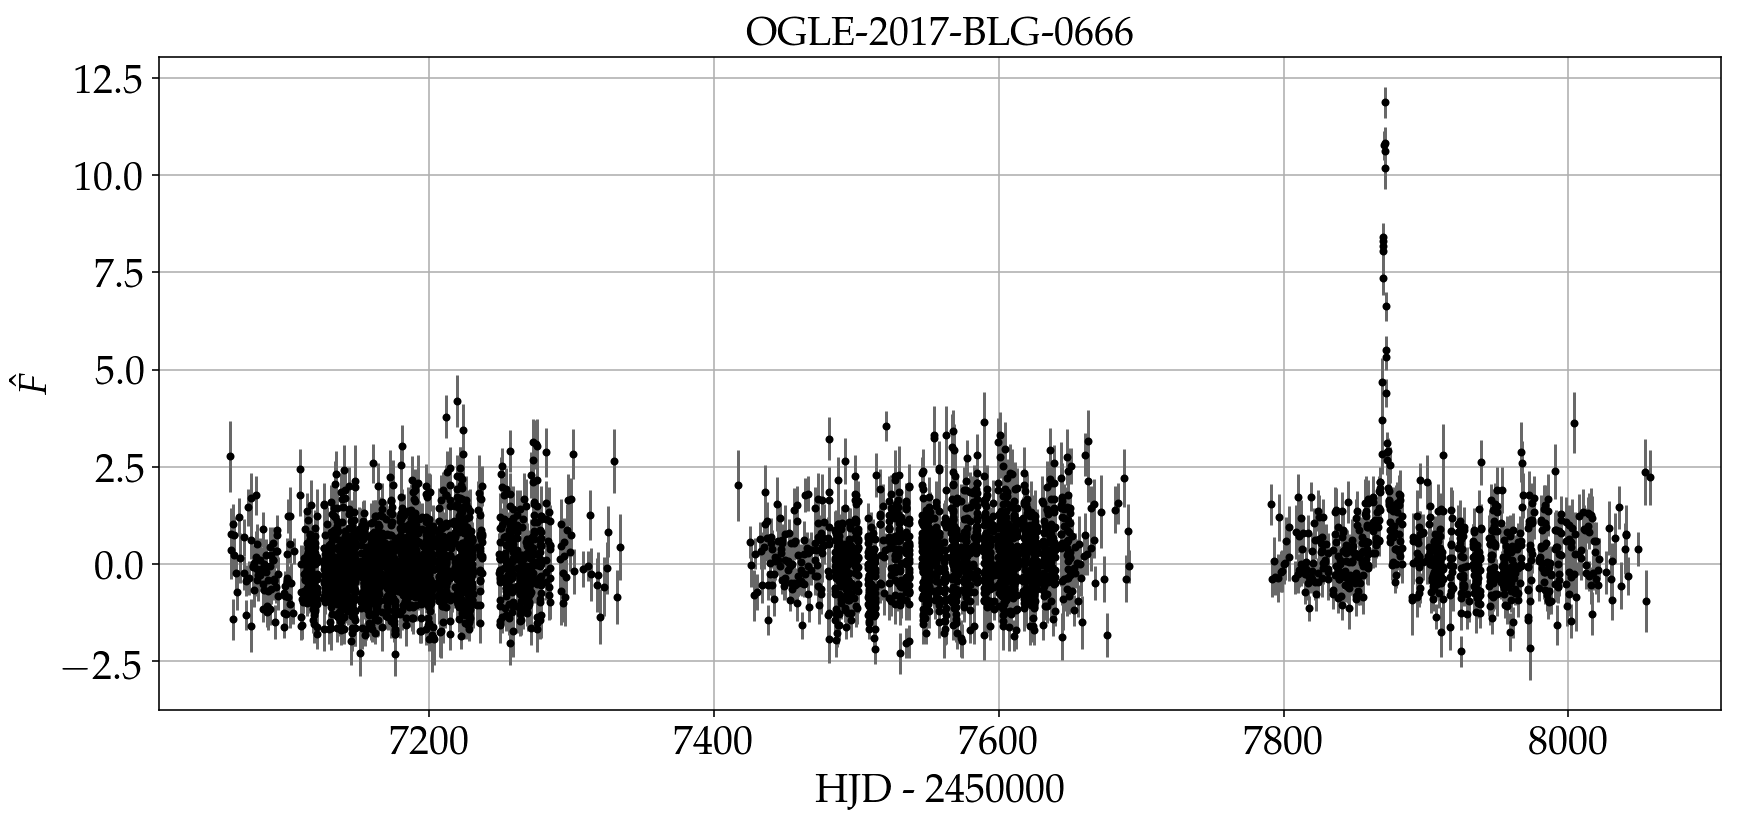

In [54]:
def rescale_fluxes(F, sig_F):
    # Subtract the median from the data such that baseline is at approx zero
    F_r = (F - np.median(F))/np.std(F)
    sig_F_r = sig_F/np.std(F)
    
    return F_r, sig_F_r

F_r, sig_F_r = rescale_fluxes(mu_F, sig_F)

fig, ax = plt.subplots(figsize=(14,6))


plot_data(ax, t, F_r, sig_F_r);
ax.set_xlabel('HJD - 2450000')
ax.set_ylabel('$\hat F$')
ax.set_title('OGLE-2017-BLG-0666');

This is the final form of the data which will be used for modelling.

# Extended Source Point Lens model (ESPL)


The classic parametrization of a microlensing light curve measured in a single filter is given by

$$F=F_s A(\boldsymbol\theta)+F_B=F_S(A+g)$$
 
where $\boldsymbol\theta$ is the parameter vector. Here $F_S$ is the flux of the source star, $A(\boldsymbol\theta)$ is the magnification which depends on the geometry and the structure of the lens as well as the source trajectory in a complicated nonlinear way. It is preferable to rewrite the above
formula by introducing the blending ratio $g=F_B/F_S$. $A$ and $g$ are dimensionless.

A better choice of parameters is 

$$F=\Delta F\frac{A(u)-1}{A(t_\textrm{eff})-1}+F_b$$

where

$$F_b = F_S+F_B,\quad\Delta F =F_S(A(t_\textrm{eff})-1)$$

and $t_\textrm{eff}=u_0t_E$.

The model parameters are then


Parameter|Description|Unit
:-----|------|----
$\Delta F$|Source star flux |energy/area|
$F_b$|Source star flux |energy/area|
$t_0$|Time of peak magnification|HJD
$\ln t_\textrm{eff}$|Effective timescale.|HJD
$\ln t_E$|Einstein crossing time|HJD
$t_*$|Angular source radius times the Einstein crossing time|ang. Einstein radius of the total mass times HJD

where $t_*=\rho_*t_E$.

## Priors for the flux parameters

Before we decide the on the prior choices, let's plot the data for a particular event.

The interpretation of the $F_b$ and $\Delta F$ parameters is very simple. $F_b$ is just the mean flux level
far away from the peak of. the microlensing event, and $\Delta F$ is the difference between the flux at the peak of the microlensing event and $F_b$. 

Both $\Delta F$ and $F_b$ are very precisely determined from the data and the choice of prior barely matters. 
Thus, we choose informative priors which ease the mcmc sampling.

$$\Delta F\sim \mathcal{N}(\textrm{max}(F), 1)$$
$$F_b\sim \mathcal{N}(0,0.1)$$

## Prior for $t_0$

$t_0$ is simply the time at which peak magnification occurs. Since the data we're working with (for now) has been condition on the fact that there is some sort of microlensing event in the light curve, $t_0$ should be within the interval $(t_{min},t_{max})$ or just outside of it. The simplest prior is just a uniform prior from
the first to the last observation time. For computational efficiency, we specify the prior as

$$\tilde t_0\sim\mathcal{U}(0., 1)$$

and then transform $\tilde t_0$ to $t_0$ as

$$t_0 = (t_\textrm{max} - t_\textrm{min})\tilde t_0+t_\textrm{min}$$

## Joint prior for $t_E$ and $t_\textrm{eff}$

Since $t_\textrm{eff}\equiv u_0 t_E$, setting independent priors on $t_\textrm{eff}$ and $t_E$ often results in silly 
values of both which don't make much sense. 
The solution is to set a join prior on both parameters. 
We have

$$p(t_\textrm{eff},t_E)\propto p(t_\textrm{eff}\lvert t_E)$$

It is easier to think about a sensible prior for $u_0$ rather than $t_\textrm{eff}$. 
For this reason, we first set a prior on $u_0$ and then use the variable transformation formula to derive a prior on 
$t_\textrm{efff}$, given $t_E$.

To get a sense of the $u_0$ parameter, let's plot the magnification for a single lens as a function of $u_0$.

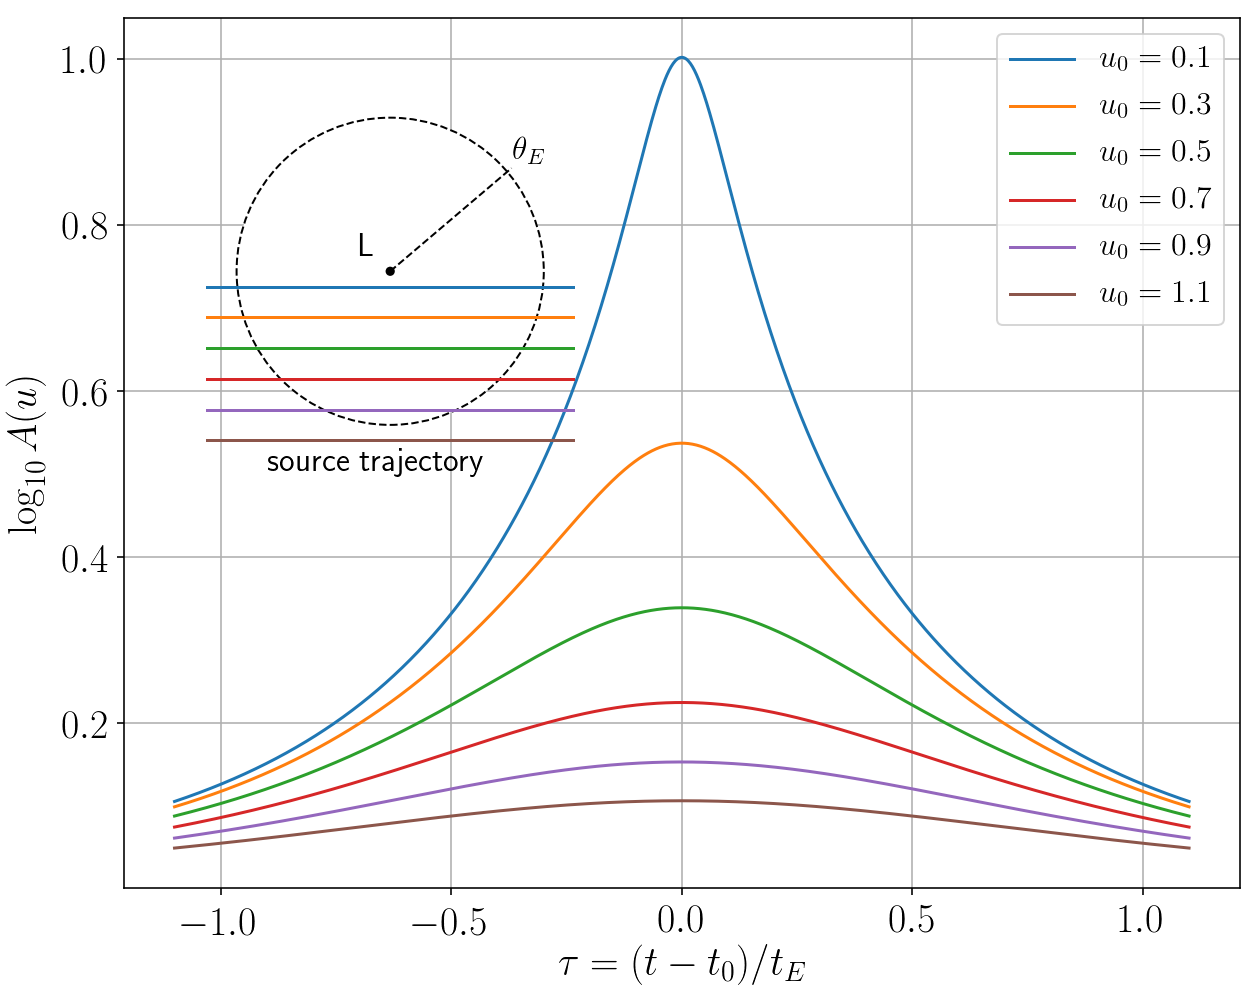

In [7]:
tau = np.linspace(-1.1, 1.1, 1000)

u0 = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1])
colors = ['C0',]

fig, ax = plt.subplots(figsize=(10,8))

for i, u0_ in enumerate(u0):
    u = np.sqrt(u0_**2 + tau**2)
    A = (u**2 + 2)/(u*np.sqrt(u**2 + 4))
    color = 'C' + str(i)
    ax.plot(tau, np.log10(A), color, label=r"$u_0="+str(u0_)+"$")

# Inset plot
a = plt.axes([0.15, 0.5, .32, .32])
# a.grid(True)
a.set_xlim(-1.2, 1.2)
a.set_ylim(-1.2, 1.2)
circle = plt.Circle((0, 0), 1., facecolor='white', edgecolor='k', linestyle='dashed', lw=1)
a.add_artist(circle)
circle2 = plt.Circle((0, 0), 0.03, facecolor='black')
a.add_artist(circle2)
a.set_aspect(1)
x_ = np.linspace(0, 0.79)
a.plot(x_, 0.85*x_, 'k--', lw=1)
a.scatter([0.], [0.], marker='o', color='black')

plt.text(-0.8, -1.3, r'source trajectory', fontsize=16)
plt.text(0.8, 0.7, r'$\theta_E$', fontsize=16)
plt.text(-0.2, 0.1, r'L', fontsize=16)
plt.axis('off')

for i, u0_ in enumerate(u0):
    u = np.sqrt(u0_**2 + tau**2)
    A = (u**2 + 2)/(u*np.sqrt(u**2 + 4))
    color = 'C' + str(i)
    a.axhline(-u0_, color=color)

ax.grid(True)
ax.set_xlabel(r"$\tau=(t-t_0)/t_E$")
ax.set_ylabel(r"$\log_{10}A(u)$")
ax.set_xticks([-1., -0.5, 0., 0.5, 1.]);
ax.legend(prop={'size': 16})

We see that the magnification drops off significantly with increasing $u_0$, and for $u_0$ above $\approx 1.2$ the 
magnification is negligible. 
A sensible prior should give very little probability to such values.
A simple choice is a Half-Normal prior:
$$u_0\sim \mathcal{N}(0, 1),\quad u_0 > 0$$

Given a prior $p(u_0)$, we have

$$p(t_\textrm{eff}(u_0)\lvert t_E)\frac{dt_\textrm{eff}}{du_0}=p(u_0\lvert t_E)
$$

$$\rightarrow 
p(t_\textrm{eff}(u_0)\lvert t_E)=\frac{1}{t_E} p(u_0)$$

Hence, the joint prior is

$$p(t_\textrm{eff}, t_E)=\frac{1}{t_E} p(u_0)\,p(t_E)$$

We also need to specify a prior for $t_E$. $t_E$ is the ang. Einstein radius crossing time, defined by

$$t_E=\frac{\theta_E}{\mu_{rel}}=\frac{1}{\mu_{rel}}\sqrt{\kappa M\pi_{rel}}$$

where $\kappa=8.144\,mas\,M_\odot^{-1}$. $\mu_{rel}$ is the magnitude of the relative angular velocity between
the source and the lens, and $\pi_{rel}$ is the relative parallax between the source and the lens.
We should go for a weakly informative prior which regularizes the allowed values of $t_E$ to sensible values, a reasonable
choice is 

$$t_E\sim\mathcal{N}(0, 365),\quad t_E>0$$

Finally, since both $t_\textrm{eff}$ and $t_E$ are both strictly positive, it is better  to sample in $(\ln t_\textrm{eff},
\ln t_E)$. 
We use the variable transformation formula once again to derive a prior
$$p(\ln t_\textrm{eff},\ln t_E)=t_\textrm{eff}\,t_E\,p(t_\textrm{eff},t_E)$$



Text(0,0.5,'$p(t_E)$')

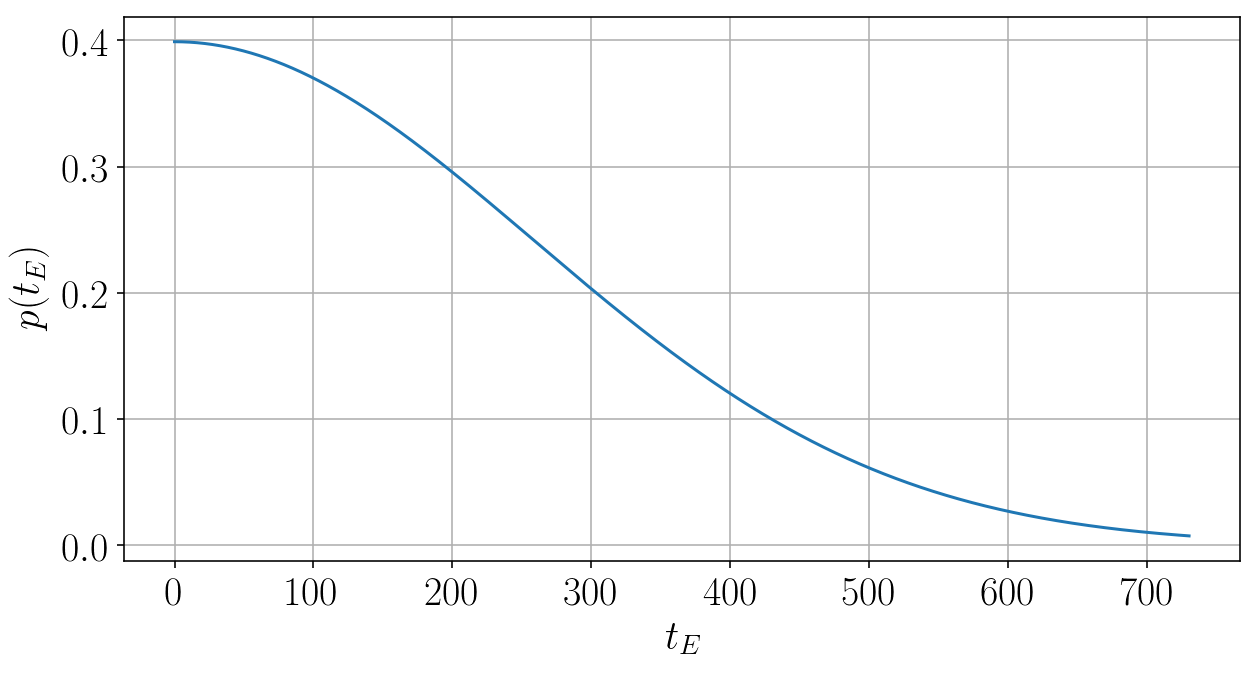

In [103]:
fig, ax = plt.subplots(figsize=(10,5))

from scipy.special import gamma 

def inverse_gamma(x, alpha, beta):
    return beta**alpha*x**(-alpha - 1)*np.exp(-beta/x)/gamma(alpha)

def gaussian(x, mu, std):
    return np.exp(-(x - mu)**2/std**2)/np.sqrt(2*np.pi*std**2)

tE = np.linspace(0, 2, 20000)

ax.plot(365*tE, gaussian(tE, 0., 1.))
ax.grid(True)
# ax.set_xlim(0, 500.)
# ax.set_xlim(0., 15)
# ax.set_ylim(0, 5.)
ax.set_xlabel(r'$t_E$')
ax.set_ylabel(r'$p(t_E)$')

Since we are pretty much completely ignorant of $u_0$ except that we know that it is very unlikely to be larger than 1,  and $t_\textrm{eff}$ is a product of $u_0$ and $t_E$, we use the same prior as for $t_E$ except that
we measure $t_\textrm{eff}$ in units of $1/10$ of a year.

## Prior for $\rho$

$\rho$ is the angular source diameter in units of Einstein radii:

$$\rho=\frac{\rho_s}{\theta_E}$$

Let's plot the light curve for a single lens event with varying source sizes.

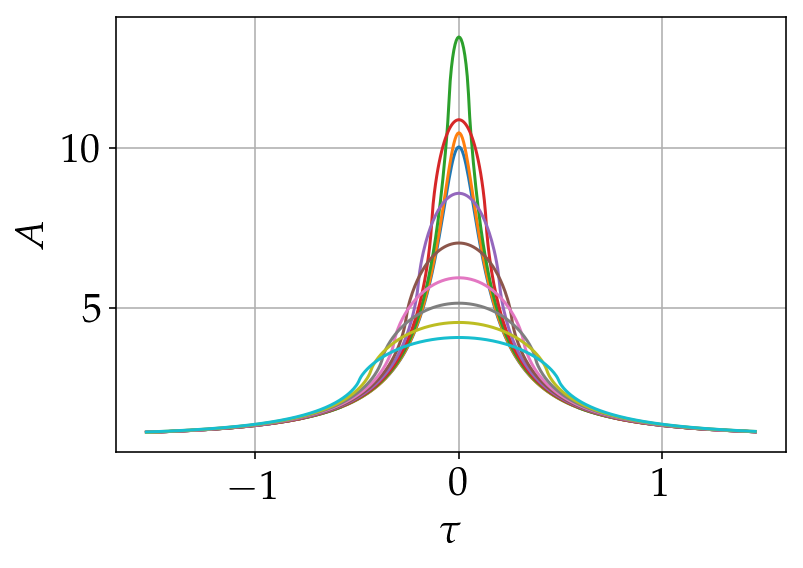

In [8]:
t = np.linspace(7000, 7300, 500)

tE = 100.3 # einstein radius crossing time
t0 = 7154. # time of peak magnification
u0 = 0.1 # impact parameter
rho = np.linspace(0., 0.5, 10)

tau = (t - t0)/tE

fig, ax = plt.subplots()
ax.grid(True)
# ax.set_xlim(-0.5, 0.5)
# ax.set_ylim(0., 2)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$A$')

for i, rho_ in enumerate(rho):
    mag = np.zeros(len(tau))
    u = np.sqrt(u0**2 + tau**2)
    
    for i in range(len(tau)):
        mag[i] = VBBL.ESPLMag2(u[i], rho_)
        
    ax.plot(tau, mag)

In the vast majority of cases (especially for single lens events) the finite source effects are negligible and the point source approximation is good enough. However, we want to be able to capture those effects if they are present because they enable measuring the angular Einstein radius. Hence we need a prior which is weighted towards zero source size but which allows large source sizes in case it can be constrained. One sensible
choice is the Exponential distribution with a mean of $0.01$.

$$\rho\sim\textrm{Exp}(1/0.01)$$

Text(0.5,0,'$\\rho$')

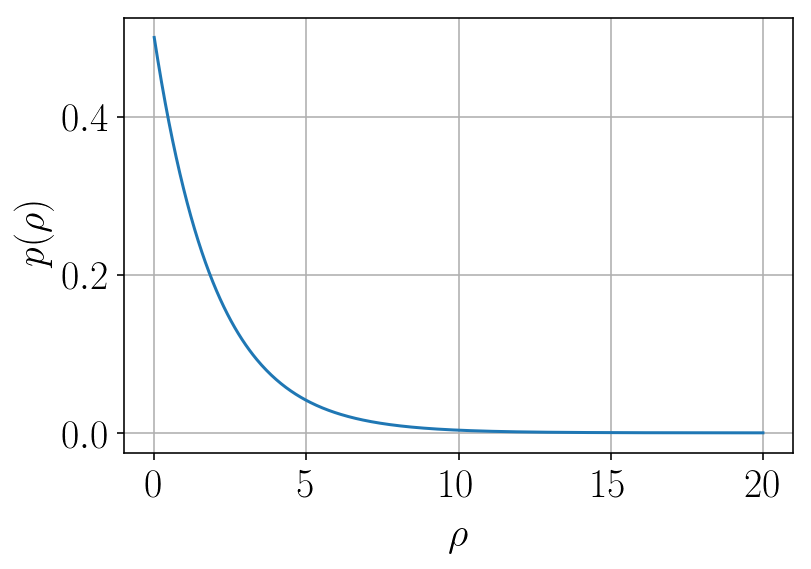

In [16]:
rho_values = np.linspace(0, 20, 500)
lambda_ = 1/2

fig, ax = plt.subplots()
ax.plot(rho_values, lambda_*np.exp(-lambda_*rho_values))
ax.grid(True)
ax.set_ylabel(r'$p(\rho)$')
ax.set_xlabel(r'$\rho$')

# The likelihood function

The likelihood function is a crucial part of the model. For now, we test three different options:
- A simple model  Gaussian likelihood
- A "robust" model Student's t likelihood with a wide tail ($\nu=4$)
- Another robust model with a Student's t likelihood where the number of degrees of freedom is a free parameter and the uncertanties for each of the data points are simultaneously rescaled by constant factor 
- A Gaussian mixture model where all of the data points have some probability of being drawn from a broad Gaussian with constant mean

## The Gaussian likelihood


$$p(F_i\rvert t_i,\sigma_{Fi},\Delta F, F_b,t_0,u_0,t_E)\sim\
\mathcal{N}\left(\Delta F A'(t_i;t_0,u_0,t_E)+F_b,\sigma_{Fi}\right)$$

where

$$A'(t_i;t_0,u_0,t_E)=\frac{A(t;t_0,u_0,t_E)-1}{A(u_0)-1}$$

## The student's t model

$$p(F_i\rvert t_i,\sigma_{Fi},\Delta F, F_b,t_0,u_0,t_E)\sim\
\mathcal{t}_4\left(\Delta F A'(t_i;t_0,u_0,t_E)+F_b,\sigma_{Fi}\right)$$

where 

$$t_4\left(\Delta F A'(t_i;t_0,u_0,t_E)+F_b,\sigma_{Fi}\right)= \\
\frac{3}{8}
\left[1 + \frac{1}{4}\frac{(F_i-
\Delta F A'(t_i;t_0,u_0,t_E)-F_b)^2}{\sigma_{Fi}^2}\right]^{-\frac{5}{2}}
$$

## The student's t spike and slab model

Instead of trusting the error bars, we can add an extra parameter which describes the degree to which we should trust the error bars. We scale all the error bars by a constant $K$,
if $K=1$ we trust the error bars and if $K>1$ the error 
bars should be scaled by $K$. Since we introduced a new
parameter we need to specify a prior for it, B. Brewer
suggests the spike and slab prior defined by

$$p(K)=\frac{1}{2}\delta(K-1)+\frac{1}{2}\begin{cases}
\exp[-(K-1)] & K>1\\
0 & K\leq 1\end{cases}$$

This is a $50-50$ mixture of a Dirac delta function at $K=1$ 
and an exponential distribution with scale $1$ for $K>1$. 
This prior expresses the idea that there's a $50\%$ chance
that $K$ is exactly one and if it's not then it's likely 
close to 1 and very unlikely to be greater than 5. Let's plot it:

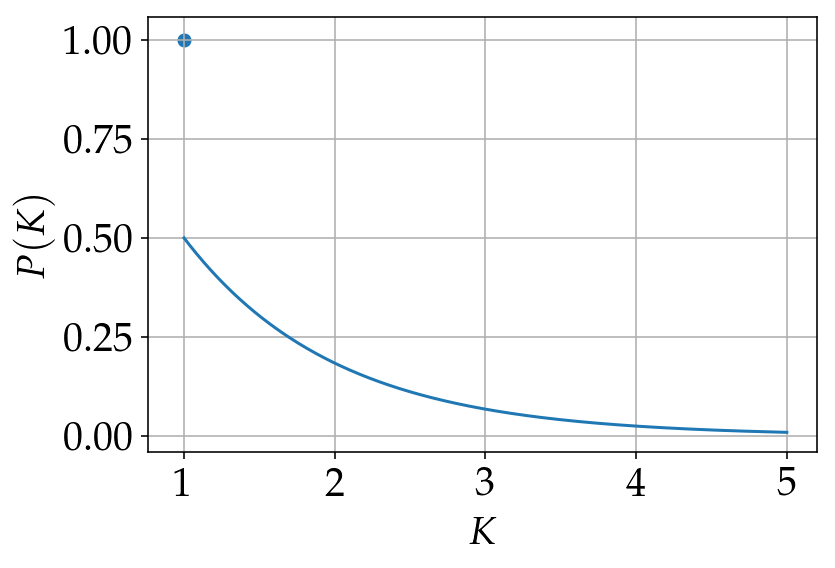

In [10]:
K = np.linspace(1., 5., 500)

fig, ax = plt.subplots()
ax.plot(K, 0.5*np.exp(-(K - 1)))
ax.scatter(1., 1.)
ax.grid(True)
ax.set_ylabel(r'$P(K)$')
ax.set_xlabel(r'$K$')

To implement this prior in MCMC we introduce a variable $u_K$
which is distributed according to $u_K\sim\mathcal{U}(-1,1)$
and we let $K=1$ if $u_K<0$ and $K=1-\log_{10} (1-u_K)$ if $u_K>0$.

At the same time we rescale the error bars we also allow the 
number of degrees of freedom in the student's t distribution, $\nu$, to vary. We opt for a prior uniform in the logarithm 
of $\nu$ such that we cover a wide range of $t$ distributions
from those with very wide tails to those which are 
indistinguishable from Gaussians. The prior is then

$$\log_{10}\nu\sim\mathcal{U}(-1,2)$$

The likelihood is then

$$p(F_i\rvert t_i,\sigma_{Fi},\Delta F, F_b,t_0,u_0,t_E)\sim\
\mathcal{t}_\nu\left(\Delta F A'(t_i;t_0,u_0,t_E)+F_b,K\sigma_{Fi}\right)$$


# Priors for the Gaussian Process hyperparameters
## Matérn 3/2 kernel

The approximate Matérsqrtn 3/2 kernel in Celerité is defined by

$$k(\tau) = \sigma^2\,\left[
    \left(1+1/\epsilon\right)\,e^{-(1-\epsilon)\sqrt{3}\,\tau/\rho}
    \left(1-1/\epsilon\right)\,e^{-(1+\epsilon)\sqrt{3}\,\tau/\rho}
\right]$$

where $\sigma$ is the standard deviation of the signal (characteristic length scale), $\rho$ is the characteristic timescale
of the variations, and $\epsilon$ is a parameter which defines how well this kernel approximates u actual Matérn 3/2 kernel.

In order to fit this GP, we need to specify a reasonable weakly informative prior which excludes physically unrealistic 
values of the characteristic lengthscale and timescale in order to prevent overfitting. 
The prior should assign very small probability to lengthscales smaller than the median spacing between the data points.
The Stan team recommends an Inverse Gamma distribution which is defined as

$$p(x)=\frac{\beta^\alpha}{\Gamma(\alpha)}x^{-\alpha-1}\exp\left(-\frac{\beta}{x}\right)$$

We choose the values of $\alpha$ and $\beta$ such that we allow 1\% of probability for timescales less than $0.5$ days and 
greater than 100 days. For the variance parameter we opt for the same prior, allowing 1\% of the pdf for variance less than
1 and greater than 10. 
To find $\alpha$ and $\beta$ for both parameters, we need to solve a system  of equations for the Inverse Gamma CDF, given by

$$F(x;\alpha,\beta)=\frac{\Gamma(\alpha,\beta/x)}{\Gamma(\alpha)}$$

In [1]:
from scipy.stats import invgamma
from scipy.optimize import fsolve

def inverse_gamma_cdf(x, alpha, beta):
    return invgamma.cdf(x, alpha, scale=beta)

def equations_rho(params):
    alpha, beta = params
    return (inverse_gamma_cdf(1., alpha, beta) - 0.01, inverse_gamma_cdf(100., alpha, beta) - 0.99)

alpha, beta =  fsolve(equations_rho, (0.1, 0.1))
print(alpha, beta)

# Plot inverse gamma distribution with those parameters
fig, ax = plt.subplots(figsize=(15, 5))

x = np.linspace(0, 25, 1000)
ax.plot(x, invgamma.pdf(x, alpha, scale=beta))
ax.grid(True)
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$p(\rho)$')

1.49419668702 5.66074081464


NameError: name 'plt' is not defined

In [33]:
# Same for the scale parameter
def equations_sigma(params):
    alpha, beta = params
    return (inverse_gamma_cdf(1, alpha, beta) - 0.01, inverse_gamma_cdf(10., alpha, beta) - 0.99)

alpha2, beta2 =  fsolve(equations_sigma, (0.1, 0.1))
print(alpha2, beta2)

4.62908951875 11.0336597978


Thus, we have

$$\rho\sim\textrm{InvGamma}(1.221,\, 2.547)$$
$$\sigma\sim\textrm{InvGamma}(4.629,\, 11.034)$$

However, celerité works with the natural logarithm of these parameters, we can find the prior for $\ln\sigma$ and 
$\ln\rho$ using the transformation formula, we have

$$p(\ln\rho)=\rho \,p(\rho)$$

and similarly for $\sigma$.